# One Pixel Attack for Fooling Deep Neural Networks
An implementation of the procedure described in https://arxiv.org/abs/1710.08864.

## Setup

In [ ]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 7.5 MB/s 


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pathlib import Path
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms, models
from tqdm import tqdm

writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")

### CUDA

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 4}
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: True


## Train CIFAR VGG16 Model

### Model Definition

In [ ]:
cifar_model = models.vgg16(pretrained=True, init_weights=False)
cifar_model.classifier = nn.Sequential(
        nn.Linear(25088, 2048),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(2048, 2048),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(2048, 10),
    )
cifar_model = cifar_model.to(DEVICE)

### Dataloading

In [ ]:
BATCH_SIZE = 128
TRAIN_COUNT = 40_000
VAL_COUNT = 10_000
TEST_COUNT = 10_000

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.ToTensor()

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set = torch.utils.data.dataset.Subset(train_set, range(0,TRAIN_COUNT))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)

val_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=test_transform)
val_set = torch.utils.data.dataset.Subset(val_set, range(TRAIN_COUNT,TRAIN_COUNT+VAL_COUNT))
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Test and Validation Function

In [ ]:
def test(epoch=None, is_validation=False):
    cifar_model.eval()
    loader = val_loader if is_validation else test_loader
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = cifar_model(inputs)
            test_loss += F.cross_entropy(outputs, targets, size_average=False).item()
            test_correct += outputs.max(1)[1].eq(targets).sum().item()
    if is_validation:
        writer.add_scalar('logs/val_loss', test_loss/len(loader.dataset), epoch)
        writer.add_scalar('logs/val_acc', test_correct/len(loader.dataset), epoch)
    else:
        print("Test Accuracy: {}/{}".format(test_correct, len(loader.dataset)))

### Train Function

In [ ]:
#optimizer = optim.Adam(cifar_model.classifier.parameters())
optimizer = optim.Adam(cifar_model.parameters())

# Training
def train(epoch):
    cifar_model.train()
    epoch_loss = 0
    epoch_correct = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        print(inputs.shape)
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = cifar_model(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        batch_correct = outputs.max(1)[1].eq(targets).sum().item()
        epoch_loss += loss.item()
        epoch_correct += batch_correct
        writer.add_scalar('logs/train_loss', loss.item(), epoch*len(train_loader) + batch_idx)
        writer.add_scalar('logs/train_acc', batch_correct / targets.size(0), epoch*len(train_loader) + batch_idx)
    test(epoch, is_validation=True)

### Train Model and Store Weights (or Load Weights)

In [ ]:
TRAIN_EPOCHS = 20
WEIGHTS_PATH = Path("./vgg_cifar_weights.pt")

if WEIGHTS_PATH.is_file():
    cifar_model.load_state_dict(torch.load(WEIGHTS_PATH))
    print("Loaded weights from file:", WEIGHTS_PATH)
else:
    for epoch in range(TRAIN_EPOCHS):
        train(epoch)
    torch.save(cifar_model.state_dict(), WEIGHTS_PATH)

  0%|          | 0/313 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 32])


  1%|          | 2/313 [00:01<02:24,  2.16it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


  2%|▏         | 5/313 [00:01<00:56,  5.49it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


  2%|▏         | 7/313 [00:01<00:43,  7.08it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


  4%|▎         | 11/313 [00:01<00:32,  9.21it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


  4%|▍         | 13/313 [00:02<00:30,  9.77it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


  5%|▌         | 17/313 [00:02<00:27, 10.63it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


  6%|▌         | 19/313 [00:02<00:27, 10.80it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


  7%|▋         | 23/313 [00:02<00:26, 11.07it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


  8%|▊         | 25/313 [00:03<00:25, 11.10it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


  9%|▉         | 29/313 [00:03<00:25, 11.13it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 10%|▉         | 31/313 [00:03<00:25, 11.20it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 11%|█         | 35/313 [00:04<00:24, 11.23it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 12%|█▏        | 37/313 [00:04<00:24, 11.29it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 13%|█▎        | 41/313 [00:04<00:24, 11.20it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 14%|█▎        | 43/313 [00:04<00:24, 11.20it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 15%|█▌        | 47/313 [00:05<00:23, 11.17it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 16%|█▌        | 49/313 [00:05<00:23, 11.15it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 17%|█▋        | 53/313 [00:05<00:23, 11.25it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 18%|█▊        | 55/313 [00:05<00:22, 11.26it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 19%|█▉        | 59/313 [00:06<00:22, 11.27it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 19%|█▉        | 61/313 [00:06<00:22, 11.24it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 21%|██        | 65/313 [00:06<00:22, 11.22it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 21%|██▏       | 67/313 [00:06<00:21, 11.25it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 23%|██▎       | 71/313 [00:07<00:21, 11.23it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 23%|██▎       | 73/313 [00:07<00:21, 11.25it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 25%|██▍       | 77/313 [00:07<00:20, 11.38it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 25%|██▌       | 79/313 [00:07<00:20, 11.32it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 27%|██▋       | 83/313 [00:08<00:20, 11.31it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 27%|██▋       | 85/313 [00:08<00:20, 11.25it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 28%|██▊       | 89/313 [00:08<00:19, 11.28it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 29%|██▉       | 91/313 [00:08<00:19, 11.29it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 30%|███       | 95/313 [00:09<00:19, 11.28it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 31%|███       | 97/313 [00:09<00:19, 11.27it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 32%|███▏      | 101/313 [00:09<00:18, 11.33it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 33%|███▎      | 103/313 [00:10<00:18, 11.26it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 34%|███▍      | 107/313 [00:10<00:18, 11.16it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 35%|███▍      | 109/313 [00:10<00:18, 11.07it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 36%|███▌      | 113/313 [00:10<00:17, 11.12it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 37%|███▋      | 115/313 [00:11<00:17, 11.20it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 38%|███▊      | 119/313 [00:11<00:17, 11.18it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 39%|███▊      | 121/313 [00:11<00:17, 11.22it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 40%|███▉      | 125/313 [00:12<00:16, 11.24it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 41%|████      | 127/313 [00:12<00:16, 11.21it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 42%|████▏     | 131/313 [00:12<00:16, 11.19it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 42%|████▏     | 133/313 [00:12<00:16, 11.20it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 44%|████▍     | 137/313 [00:13<00:15, 11.18it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 44%|████▍     | 139/313 [00:13<00:15, 11.15it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 46%|████▌     | 143/313 [00:13<00:15, 11.27it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 46%|████▋     | 145/313 [00:13<00:14, 11.25it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 48%|████▊     | 149/313 [00:14<00:14, 11.24it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 48%|████▊     | 151/313 [00:14<00:14, 11.29it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 50%|████▉     | 155/313 [00:14<00:13, 11.29it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 50%|█████     | 157/313 [00:14<00:13, 11.28it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 51%|█████▏    | 161/313 [00:15<00:13, 11.24it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 52%|█████▏    | 163/313 [00:15<00:13, 11.27it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 53%|█████▎    | 167/313 [00:15<00:13, 11.22it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 54%|█████▍    | 169/313 [00:15<00:12, 11.20it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 55%|█████▌    | 173/313 [00:16<00:12, 11.14it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 56%|█████▌    | 175/313 [00:16<00:12, 11.19it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 57%|█████▋    | 179/313 [00:16<00:12, 11.16it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 58%|█████▊    | 181/313 [00:17<00:11, 11.10it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 59%|█████▉    | 185/313 [00:17<00:11, 11.14it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 60%|█████▉    | 187/313 [00:17<00:11, 11.11it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 61%|██████    | 191/313 [00:17<00:11, 11.08it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 62%|██████▏   | 193/313 [00:18<00:10, 11.12it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 63%|██████▎   | 197/313 [00:18<00:10, 11.13it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 64%|██████▎   | 199/313 [00:18<00:10, 11.05it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 65%|██████▍   | 203/313 [00:18<00:09, 11.17it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 65%|██████▌   | 205/313 [00:19<00:09, 11.11it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 67%|██████▋   | 209/313 [00:19<00:09, 11.12it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 67%|██████▋   | 211/313 [00:19<00:09, 11.18it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 69%|██████▊   | 215/313 [00:20<00:08, 11.15it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 69%|██████▉   | 217/313 [00:20<00:08, 11.19it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 71%|███████   | 221/313 [00:20<00:08, 11.17it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 71%|███████   | 223/313 [00:20<00:08, 11.18it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 73%|███████▎  | 227/313 [00:21<00:07, 11.16it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 73%|███████▎  | 229/313 [00:21<00:07, 11.12it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 74%|███████▍  | 233/313 [00:21<00:07, 11.14it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 75%|███████▌  | 235/313 [00:21<00:06, 11.20it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 76%|███████▋  | 239/313 [00:22<00:06, 11.11it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 77%|███████▋  | 241/313 [00:22<00:06, 11.06it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 78%|███████▊  | 245/313 [00:22<00:06, 11.14it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 79%|███████▉  | 247/313 [00:22<00:05, 11.15it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 80%|████████  | 251/313 [00:23<00:05, 11.13it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 81%|████████  | 253/313 [00:23<00:05, 11.09it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 82%|████████▏ | 257/313 [00:23<00:05, 11.12it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 83%|████████▎ | 259/313 [00:24<00:04, 11.02it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 84%|████████▍ | 263/313 [00:24<00:04, 10.96it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 85%|████████▍ | 265/313 [00:24<00:04, 10.93it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 86%|████████▌ | 269/313 [00:24<00:04, 10.94it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 87%|████████▋ | 271/313 [00:25<00:03, 11.01it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 88%|████████▊ | 275/313 [00:25<00:03, 10.80it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 88%|████████▊ | 277/313 [00:25<00:03, 10.83it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 90%|████████▉ | 281/313 [00:26<00:02, 10.92it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 90%|█████████ | 283/313 [00:26<00:02, 10.97it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 92%|█████████▏| 287/313 [00:26<00:02, 10.94it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 92%|█████████▏| 289/313 [00:26<00:02, 11.00it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 94%|█████████▎| 293/313 [00:27<00:01, 11.03it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 94%|█████████▍| 295/313 [00:27<00:01, 11.04it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 96%|█████████▌| 299/313 [00:27<00:01, 11.10it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 96%|█████████▌| 301/313 [00:27<00:01, 11.10it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 97%|█████████▋| 305/313 [00:28<00:00, 11.03it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 98%|█████████▊| 307/313 [00:28<00:00, 10.96it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


 99%|█████████▉| 311/313 [00:28<00:00, 10.89it/s]

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


100%|██████████| 313/313 [00:28<00:00, 10.79it/s]

torch.Size([64, 3, 32, 32])



/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### Test Model Accuracy

In [ ]:
test()

Test Accuracy: 3981/10000


## Attack CIFAR Model

In [ ]:
CIFAR_LABELS = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def tell(img, label, model, target_label=None):
    print("True Label:", CIFAR_LABELS[label], label)
    print("Prediction:", CIFAR_LABELS[model(img.unsqueeze(0)).max(-1)[1]], model(img.unsqueeze(0)).max(-1)[1][0].item())
    print("Label Probabilities:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0))
    print("True Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    if target_label is not None:
        print("Target Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[target_label].item())

### Prediction

True Label: deer 4
Prediction: deer 4
Label Probabilities: tensor([0.0356, 0.0039, 0.1951, 0.0765, 0.2591, 0.1071, 0.0680, 0.2306, 0.0167,
        0.0074], device='cuda:0', grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.2591334879398346


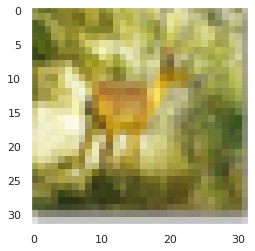

In [ ]:
test_img, test_label = test_set[500]
test_img = test_img.to(DEVICE)
show(test_img)
tell(test_img, test_label, cifar_model)

### Perturbation

Perturbation: [0.6  0.6  0.   0.   0.75]
True Label: deer 4
Prediction: ship 8
Label Probabilities: tensor([0.1771, 0.0808, 0.1023, 0.0705, 0.0833, 0.0604, 0.0560, 0.0856, 0.1820,
        0.1020], device='cuda:0', grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.0832570418715477


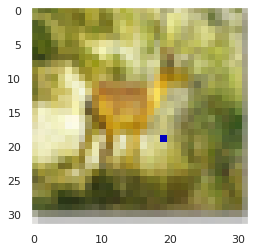

In [ ]:
def perturb(p, img):
    # Elements of p should be in range [0,1]
    img_size = img.size(1) # C x _H_ x W, assume H == W
    p_img = img.clone()
    xy = (p[0:2].copy() * img_size).astype(int)
    xy = np.clip(xy, 0, img_size-1)
    rgb = p[2:5].copy()
    rgb = np.clip(rgb, 0, 1)
    p_img[:,xy[0],xy[1]] = torch.from_numpy(rgb)
    return p_img

def visualize_perturbation(p, img, label, model, target_label=None):
    p_img = perturb(p, img)
    print("Perturbation:", p)
    show(p_img)
    tell(p_img, label, model, target_label)

visualize_perturbation(np.array([0.6,0.6,0,0,0.75]), test_img, test_label, cifar_model)

### Untargeted and Targeted Attacks

Target Probability [Iteration 0]: 0.0902310162782669
Target Probability [Iteration 10]: 0.0742567777633667
Target Probability [Iteration 20]: 0.06781413406133652
Target Probability [Iteration 30]: 0.06630834937095642
Target Probability [Iteration 40]: 0.06242143362760544
Target Probability [Iteration 50]: 0.06042906269431114
Target Probability [Iteration 60]: 0.06042906269431114
Target Probability [Iteration 70]: 0.059887226670980453
Target Probability [Iteration 80]: 0.05963102728128433
Target Probability [Iteration 90]: 0.0594525970518589
Perturbation: [0.81476585 0.49215771 0.99979986 0.99973295 0.99967512]
True Label: deer 4
Prediction: ship 8
Label Probabilities: tensor([0.1573, 0.1383, 0.0759, 0.0610, 0.0594, 0.0450, 0.0479, 0.0586, 0.1950,
        0.1617], device='cuda:0', grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.05941907688975334


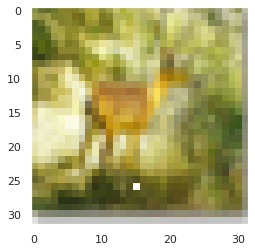

In [ ]:
def evaluate(candidates, img, label, model):
    preds = []
    model.eval()
    with torch.no_grad():
        for i, xs in enumerate(candidates):
            p_img = perturb(xs, img)
            preds.append(F.softmax(model(p_img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    return np.array(preds)

def evolve(candidates, F=0.5, strategy="clip"):
    gen2 = candidates.copy()
    num_candidates = len(candidates)
    for i in range(num_candidates):
        x1, x2, x3 = candidates[np.random.choice(num_candidates, 3, replace=False)]
        x_next = (x1 + F*(x2 - x3))
        if strategy == "clip":
            gen2[i] = np.clip(x_next, 0, 1)
        elif strategy == "resample":
            x_oob = np.logical_or((x_next < 0), (1 < x_next))
            x_next[x_oob] = np.random.random(5)[x_oob]
            gen2[i] = x_next
    return gen2

def attack(model, img, true_label, target_label=None, iters=100, pop_size=400, verbose=True):
    # Targeted: maximize target_label if given (early stop > 50%)
    # Untargeted: minimize true_label otherwise (early stop < 5%)
    candidates = np.random.random((pop_size,5))
    candidates[:,2:5] = np.clip(np.random.normal(0.5, 0.5, (pop_size, 3)), 0, 1)
    is_targeted = target_label is not None
    label = target_label if is_targeted else true_label
    fitness = evaluate(candidates, img, label, model)
    
    def is_success():
        return (is_targeted and fitness.max() > 0.5) or ((not is_targeted) and fitness.min() < 0.05)
    
    for iteration in range(iters):
        # Early Stopping
        if is_success():
            break
        if verbose and iteration%10 == 0: # Print progress
            print("Target Probability [Iteration {}]:".format(iteration), fitness.max() if is_targeted else fitness.min())
        # Generate new candidate solutions
        new_gen_candidates = evolve(candidates, strategy="resample")
        # Evaluate new solutions
        new_gen_fitness = evaluate(new_gen_candidates, img, label, model)
        # Replace old solutions with new ones where they are better
        successors = new_gen_fitness > fitness if is_targeted else new_gen_fitness < fitness
        candidates[successors] = new_gen_candidates[successors]
        fitness[successors] = new_gen_fitness[successors]
    best_idx = fitness.argmax() if is_targeted else fitness.argmin()
    best_solution = candidates[best_idx]
    best_score = fitness[best_idx]
    if verbose:
        visualize_perturbation(best_solution, img, true_label, model, target_label)
    return is_success(), best_solution, best_score

# Untargeted attack
_ = attack(cifar_model, test_img, test_label)

In [ ]:
# Targeted attack
# This is much harder/costlier than an untargeted attack
# For time reasons, targeted attacks below use 20 iterations
targeted_results = {}
for idx in range(len(CIFAR_LABELS)):
    if idx != test_label:
        targeted_results[idx] = attack(cifar_model, test_img, test_label, target_label=idx, iters=20, verbose=False)
        print(CIFAR_LABELS[idx], idx, targeted_results[idx][0], targeted_results[idx][2])
    else:
        print(CIFAR_LABELS[idx], idx, "True Label")

airplane 0 False 0.1740635335445404
automobile 1 False 0.12168442457914352
bird 2 False 0.22190722823143005
cat 3 False 0.0955909863114357
deer 4 True Label
dog 5 False 0.11348749697208405
frog 6 False 0.12367325276136398
horse 7 False 0.35071662068367004
ship 8 False 0.18509942293167114
truck 9 False 0.15540391206741333


In [ ]:
! pip install watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 7.6 MB/s 


In [ ]:
%load_ext watermark
%watermark --updated --datename --python --machine --watermark -p torch,numpy,matplotlib,tensorboardX,torchvision,seaborn,tqdm

Last updated: Wed Nov 16 2022

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0

torch       : 1.12.1+cu113
numpy       : 1.21.6
matplotlib  : 3.2.2
tensorboardX: 2.5.1
torchvision : 0.13.1+cu113
seaborn     : 0.11.2
tqdm        : 4.64.1

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.10.133+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

Watermark: 2.3.1

